In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

os.getcwd()

'/content'

In [9]:
import matplotlib.pyplot as plt             # 그래프를 그리기 위한 라이브러리
import numpy as np                          # 선형대수 라이브러리 
import networkx as nx                       # 그래프의 기본적인 연산들을 위한 라이브러리
from networkx.algorithms import community   # modularity 계산을 위한 라이브러리, community 분석 관련

G = nx.Graph()  # 방향성 없음
f = open('drive/MyDrive/data/lab/lab5/community_graph.txt')    # 만약 그래프가 잘 로딩되지않는다면, ls/cd 명령어를 통해 해결 가능
for line in f:
    v1, v2 = map(int, line.split())
    G.add_edge(v1, v2)


szCom1 = 8          # nodeColor: Red
szCom2 = 10         # nodeColor: Yellow
szCom3 = 12         # nodeColor: Blue
nodeColorList=[]
for i in range(szCom1+szCom2+szCom3):
    if i<szCom1:
        nodeColorList = nodeColorList + ['red']
    elif i<szCom1+szCom2:
        nodeColorList = nodeColorList + ['yellow']
    else:
        nodeColorList = nodeColorList + ['blue']

In [10]:
print("그래프의 노드의 개수는 {}, 엣지의 개수는 {}개입니다.".format(G.number_of_nodes(), G.number_of_edges()))

그래프의 노드의 개수는 30, 엣지의 개수는 90개입니다.


In [11]:
def GirvanNewmanAlgorithm(G, nodeColorList):
    # 복사하는 이유 : 알고리즘 수행되면서 입력 그래프의 간선들이 제거되기 때문
    # 나중에 군집성이 최대화되는 지점 복원하기 위해서는
    # 원래 입력그래프의 상태를 보존해야 한다
    copyG = G.copy()                                                        # 기존 그래프를 복사하여, 복사된 그래프를 사용하여 엣지를 하나씩 제거하는 작업을 진행한다.
    pos = nx.spring_layout(copyG)

    """ 초기화 """
    step = 0                                                                # 엣지를 하나 제거할 때마다 한 step 증가
    
    # 군집성이 iteration에 따라 어떻게 변화하는지 기록
    logModularityList = []                                                  # 후에 modularity를 plot하기 위하여 값들을 저장    
    
    # modularity(군집성)이 최대가 되는 지점에서의 커뮤니티 정보 저장
    maxModCom = []                                                          # comRecord 는 modularity가 최대일 때의 커뮤니티의 정보들을 저장
    
    # 군집성이 최대화가 된 상태의 군집성을 저장하는 용도
    maxMod = -1                                                             # maxMod은 modularity가 최대일 때 값 기록, modularity 값의 범위는 [-1,1]
    
    # 군집성이 최대가 되었을 때의 iteration 기록
    maxStep = 0                                                             # maxStep은 modularity가 최대일 때 step값 기록

    """ Girvan-Newman algorithm """
    # 종료 조건: 현재 그래프에 간선이 남아있지 않을 때까지
    while len(copyG.edges()) > 0: 
        """ 현재 상태에서의 군집성 계산, 최대치 저장 """                                                          # 모든 엣지가 사라질때까지 진행한다. 
        # nx.connected_components : 연결 요소 추출
        # recComList : 연결 요소 저장
        recComList = sorted(nx.connected_components(copyG), key=len, reverse=True)          # 현재 그래프에 존재하는 커뮤니티를 나타낸다. [{Com1}, {Com2}, {Com3} ... ]
        
        # Girvan-Newman은 각 연결 요소를 하나의 군집으로 간주하고 군집성 측정
        # community.modularity : 군집성 계산
        # recMod : 현재의 군집성
        recMod = community.modularity(G, communities=recComList)                            # 추출된 커뮤니티의 modularity 계산
        
        # 군집성 최대화 되는 지점 정보 저장 위해서
        # 군집성 최대가 된 지점 복원 가능해진다
        if recMod > maxMod:                                                                 # 이전 최대 modularity보다 현재 modularity가 높을 경우 기록
            maxModG = copyG.copy()  # 그래프
            maxMod = recMod  # 군집성
            maxModCom = []  # 현재 상태의 community도 저장
            # 현재 상태의 community는 현재 상태의 연결 요소와 동일
            for j in range(len(recComList)):
                maxModCom = maxModCom + [recComList[j]]
            maxStep = step
            
        logModularityList = logModularityList + [recMod]                    # plot을 위해 저장한다.

        """ remove edge """
        # 매개 중심성이 가장 큰 간선을 찾아 순차적으로 제거
        step = step + 1
        # nx.edge_betweenness_centrality : 간선별 매개 중심성 측정
        # betweenness : 간선별 매개 중심성 저장
        betweenness = nx.edge_betweenness_centrality(copyG)                 # betweennes centrality 계산
        
        # 매개 중심성이 가장 큰 간선 찾아서 max_Edge에 저장
        maxEdge = max(betweenness, key=betweenness.get)                     # betweeness centrality가 가장 큰 엣지 선택

        nx.draw_networkx_nodes(copyG, pos, node_color= nodeColorList, node_size=100)
        nx.draw_networkx_edges(copyG, pos, edgelist=set(copyG.edges)-set(maxEdge), alpha=0.3)           # alpha: 기존 엣지들의 투명도를 조절하여 삭제되는 엣지가 돋보이도록하는 코드, alpha가 커질수록 진해짐.
        nx.draw_networkx_edges(copyG, pos, edgelist={maxEdge}, edge_color='black')         # 삭제 되는 엣지
        plt.show()
        print("Step: ", step, " ↑Modularity↑: ", recMod)

        # 그래프의 현재 상태에서 maxEdge 제거
        copyG.remove_edge(maxEdge[0], maxEdge[1])                               # 엣지를 제거한다.

    return maxModG, maxMod, maxModCom, maxStep, logModularityList

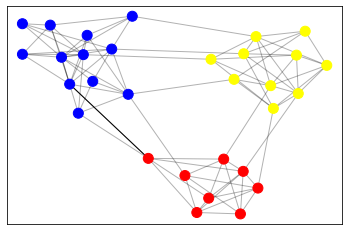

Step:  1  ↑Modularity↑:  0.0


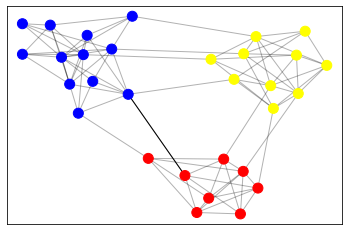

Step:  2  ↑Modularity↑:  0.0


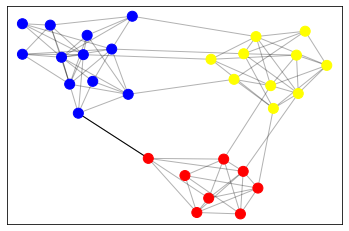

Step:  3  ↑Modularity↑:  0.0


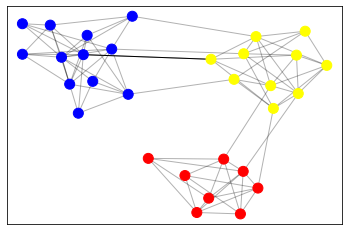

Step:  4  ↑Modularity↑:  0.0


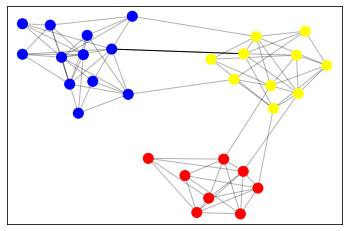

Step:  5  ↑Modularity↑:  0.0


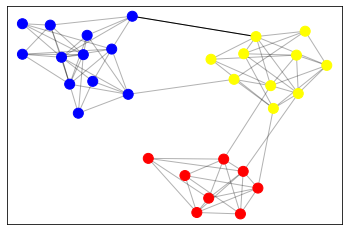

Step:  6  ↑Modularity↑:  0.0


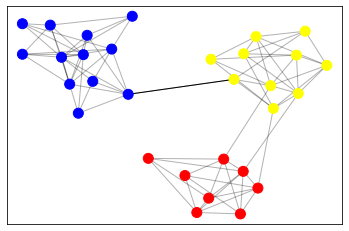

Step:  7  ↑Modularity↑:  0.0


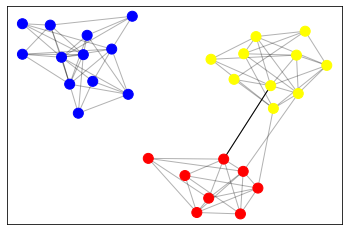

Step:  8  ↑Modularity↑:  0.4117901234567901


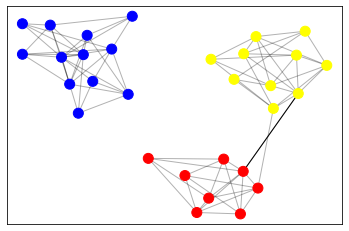

Step:  9  ↑Modularity↑:  0.4117901234567901


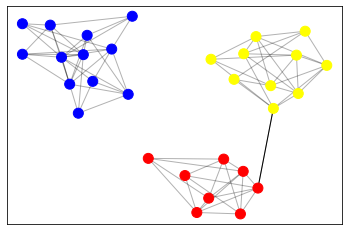

Step:  10  ↑Modularity↑:  0.4117901234567901


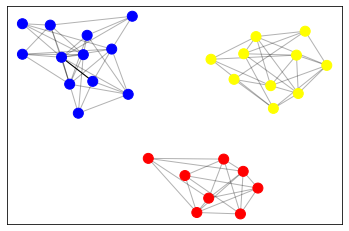

Step:  11  ↑Modularity↑:  0.5403086419753086


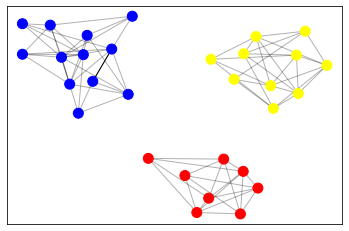

Step:  12  ↑Modularity↑:  0.5403086419753086


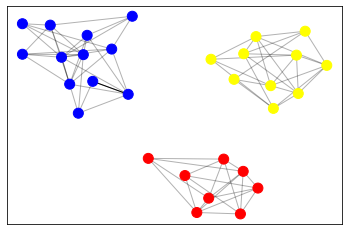

Step:  13  ↑Modularity↑:  0.5403086419753086


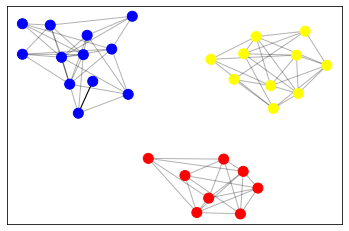

Step:  14  ↑Modularity↑:  0.5403086419753086


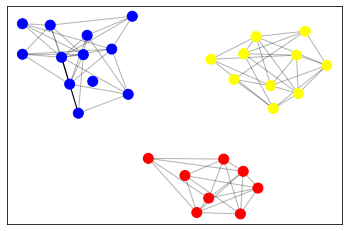

Step:  15  ↑Modularity↑:  0.5138888888888888


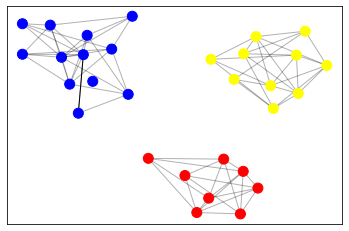

Step:  16  ↑Modularity↑:  0.5138888888888888


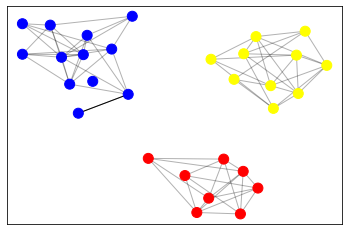

Step:  17  ↑Modularity↑:  0.5138888888888888


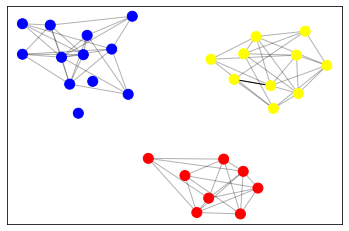

Step:  18  ↑Modularity↑:  0.5015432098765432


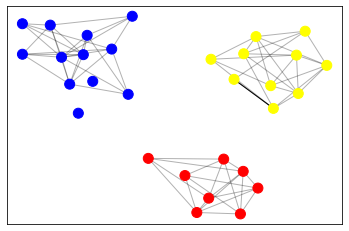

Step:  19  ↑Modularity↑:  0.5015432098765432


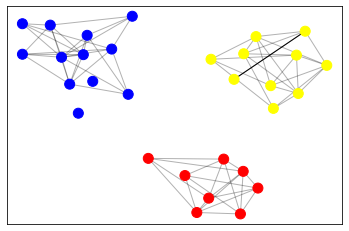

Step:  20  ↑Modularity↑:  0.5015432098765432


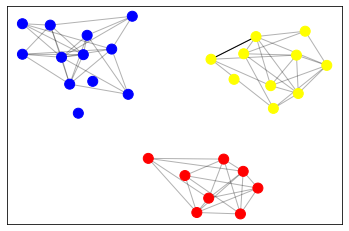

Step:  21  ↑Modularity↑:  0.4812962962962963


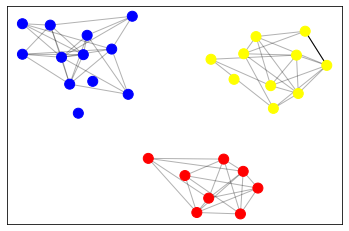

Step:  22  ↑Modularity↑:  0.4812962962962963


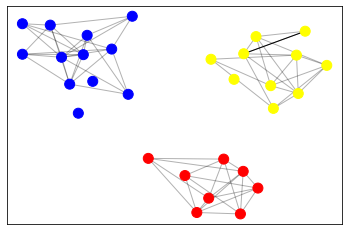

Step:  23  ↑Modularity↑:  0.4812962962962963


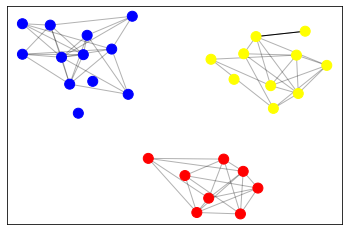

Step:  24  ↑Modularity↑:  0.4812962962962963


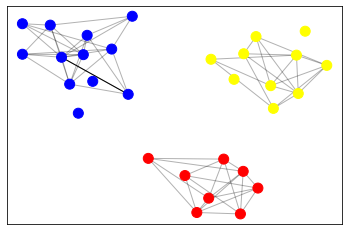

Step:  25  ↑Modularity↑:  0.46006172839506165


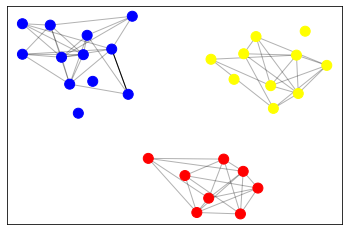

Step:  26  ↑Modularity↑:  0.46006172839506165


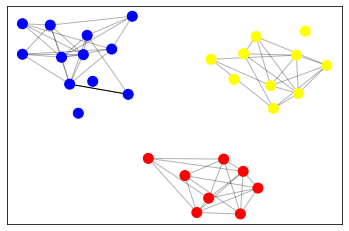

Step:  27  ↑Modularity↑:  0.46006172839506165


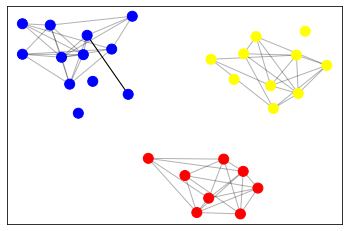

Step:  28  ↑Modularity↑:  0.46006172839506165


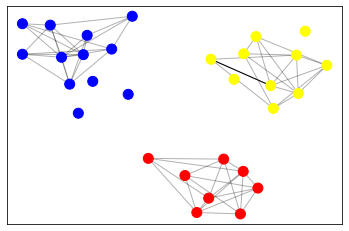

Step:  29  ↑Modularity↑:  0.4452469135802469


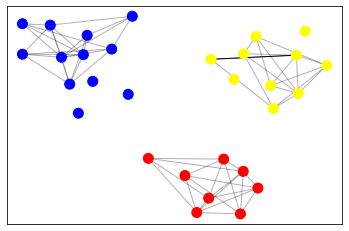

Step:  30  ↑Modularity↑:  0.4452469135802469


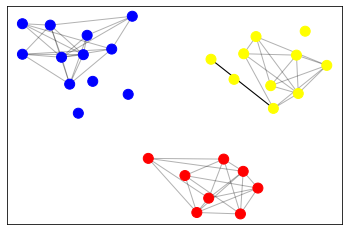

Step:  31  ↑Modularity↑:  0.4452469135802469


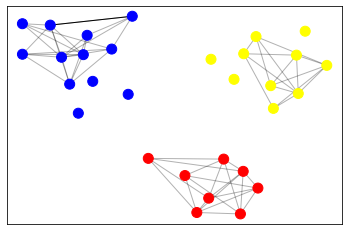

Step:  32  ↑Modularity↑:  0.41438271604938265


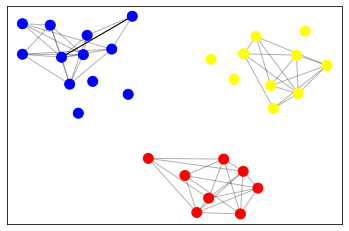

Step:  33  ↑Modularity↑:  0.41438271604938265


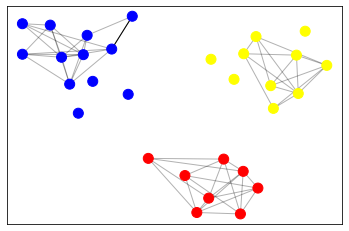

Step:  34  ↑Modularity↑:  0.41438271604938265


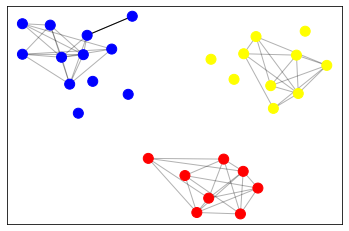

Step:  35  ↑Modularity↑:  0.41438271604938265


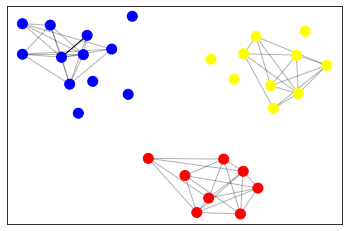

Step:  36  ↑Modularity↑:  0.38691358024691347


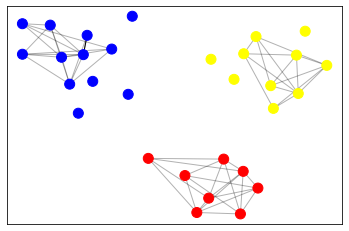

Step:  37  ↑Modularity↑:  0.38691358024691347


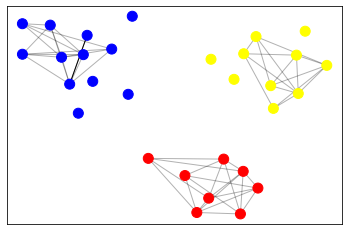

Step:  38  ↑Modularity↑:  0.38691358024691347


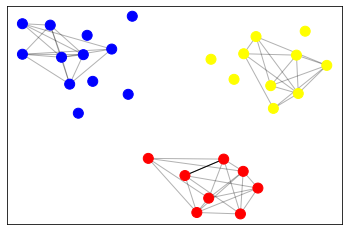

Step:  39  ↑Modularity↑:  0.36901234567901225


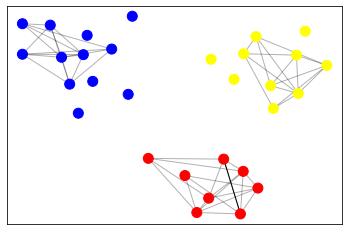

Step:  40  ↑Modularity↑:  0.36901234567901225


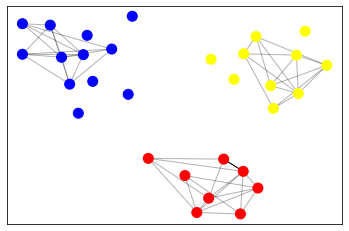

Step:  41  ↑Modularity↑:  0.36901234567901225


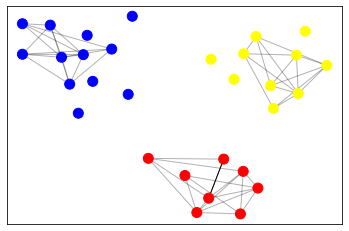

Step:  42  ↑Modularity↑:  0.36901234567901225


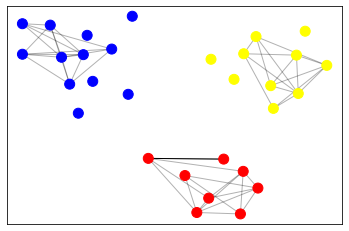

Step:  43  ↑Modularity↑:  0.36901234567901225


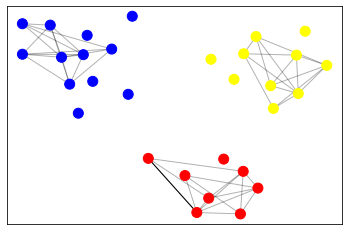

Step:  44  ↑Modularity↑:  0.3282716049382715


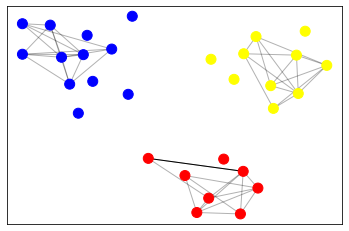

Step:  45  ↑Modularity↑:  0.3282716049382715


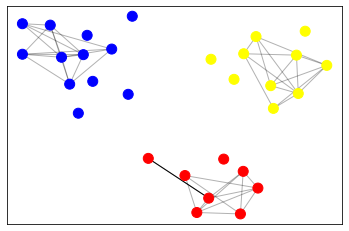

Step:  46  ↑Modularity↑:  0.3282716049382715


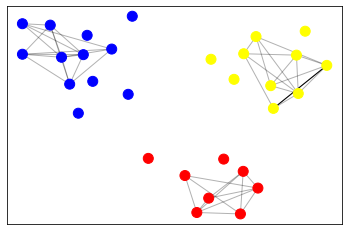

Step:  47  ↑Modularity↑:  0.3075308641975308


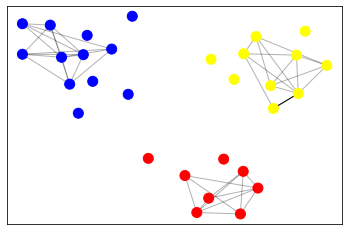

Step:  48  ↑Modularity↑:  0.3075308641975308


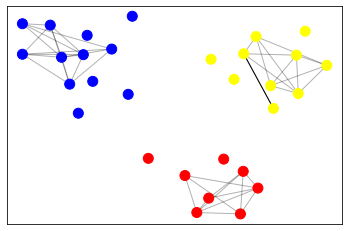

Step:  49  ↑Modularity↑:  0.3075308641975308


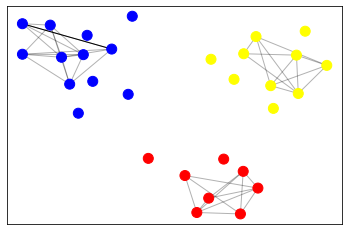

Step:  50  ↑Modularity↑:  0.2882716049382715


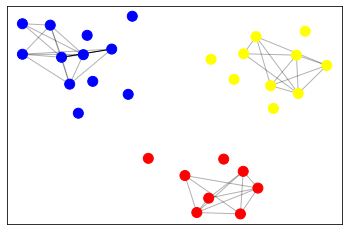

Step:  51  ↑Modularity↑:  0.2882716049382715


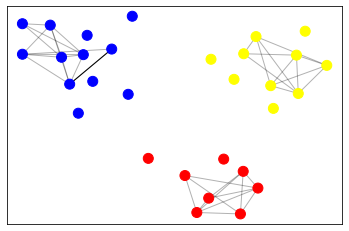

Step:  52  ↑Modularity↑:  0.2882716049382715


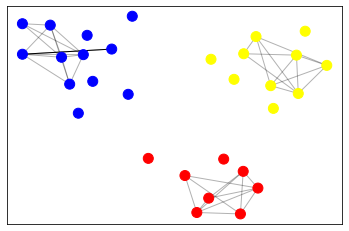

Step:  53  ↑Modularity↑:  0.2882716049382715


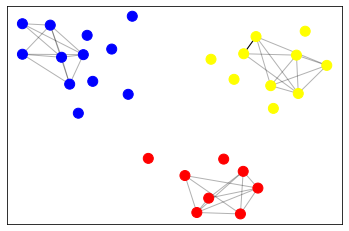

Step:  54  ↑Modularity↑:  0.26456790123456775


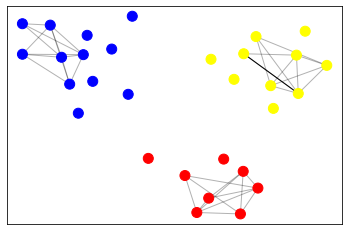

Step:  55  ↑Modularity↑:  0.26456790123456775


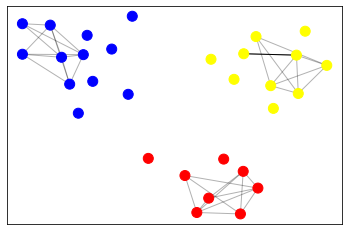

Step:  56  ↑Modularity↑:  0.26456790123456775


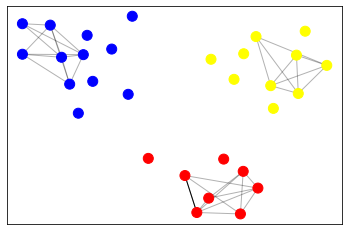

Step:  57  ↑Modularity↑:  0.24308641975308637


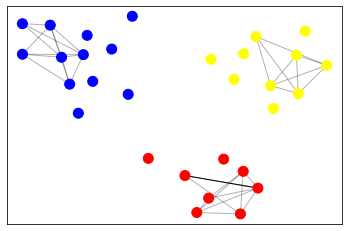

Step:  58  ↑Modularity↑:  0.24308641975308637


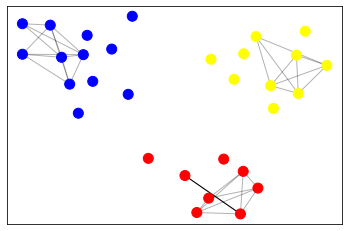

Step:  59  ↑Modularity↑:  0.24308641975308637


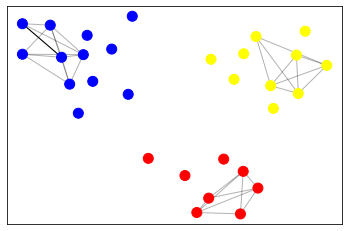

Step:  60  ↑Modularity↑:  0.21870370370370368


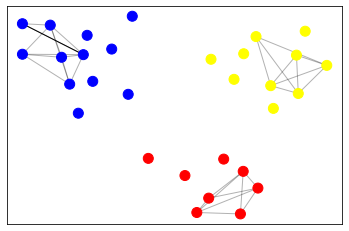

Step:  61  ↑Modularity↑:  0.21870370370370368


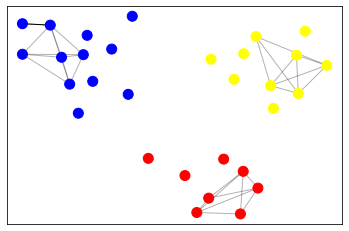

Step:  62  ↑Modularity↑:  0.21870370370370368


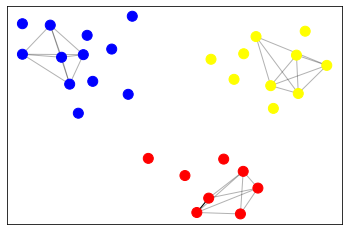

Step:  63  ↑Modularity↑:  0.19475308641975309


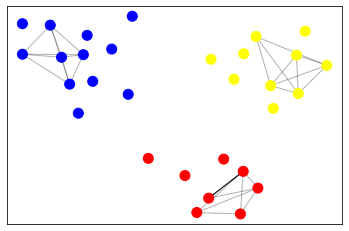

Step:  64  ↑Modularity↑:  0.19475308641975309


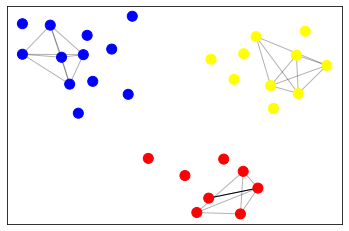

Step:  65  ↑Modularity↑:  0.19475308641975309


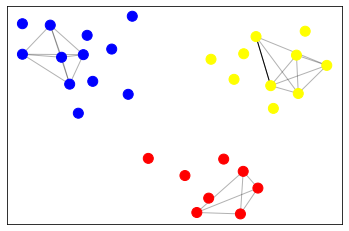

Step:  66  ↑Modularity↑:  0.16882716049382712


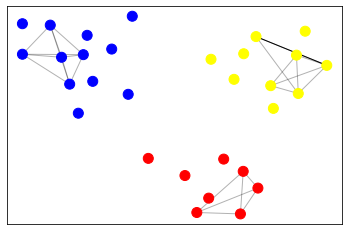

Step:  67  ↑Modularity↑:  0.16882716049382712


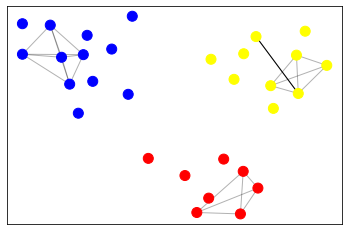

Step:  68  ↑Modularity↑:  0.16882716049382712


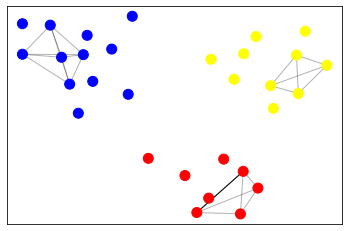

Step:  69  ↑Modularity↑:  0.14629629629629629


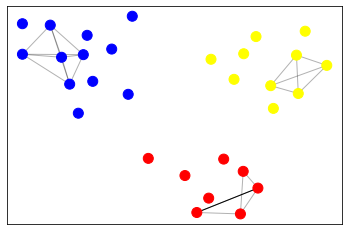

Step:  70  ↑Modularity↑:  0.14629629629629629


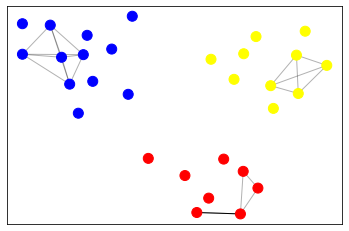

Step:  71  ↑Modularity↑:  0.14629629629629629


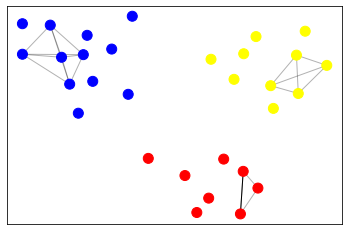

Step:  72  ↑Modularity↑:  0.11962962962962961


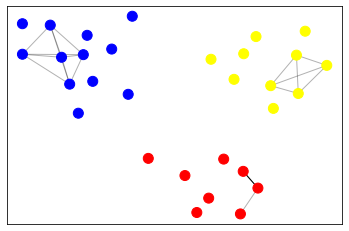

Step:  73  ↑Modularity↑:  0.11962962962962961


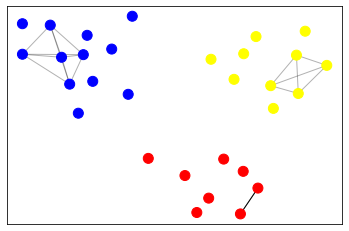

Step:  74  ↑Modularity↑:  0.10216049382716048


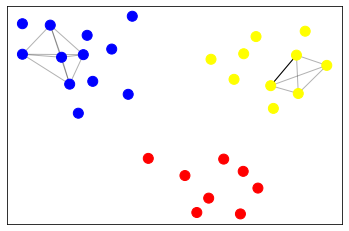

Step:  75  ↑Modularity↑:  0.09290123456790123


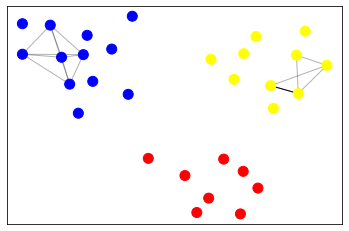

Step:  76  ↑Modularity↑:  0.09290123456790123


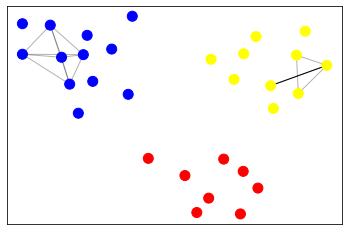

Step:  77  ↑Modularity↑:  0.09290123456790123


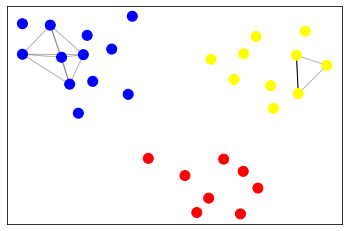

Step:  78  ↑Modularity↑:  0.06734567901234567


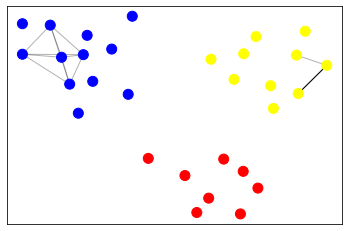

Step:  79  ↑Modularity↑:  0.06734567901234567


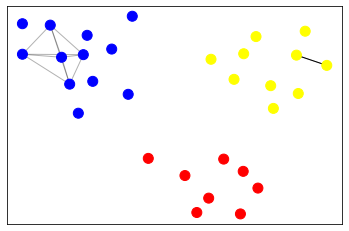

Step:  80  ↑Modularity↑:  0.04987654320987654


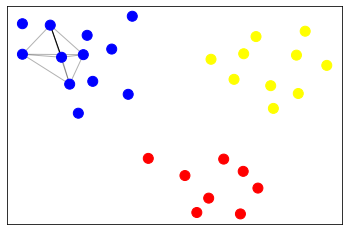

Step:  81  ↑Modularity↑:  0.04061728395061727


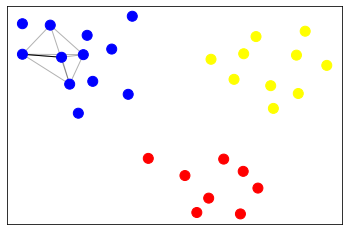

Step:  82  ↑Modularity↑:  0.04061728395061727


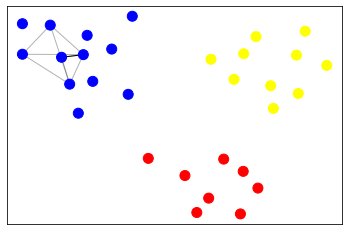

Step:  83  ↑Modularity↑:  0.04061728395061727


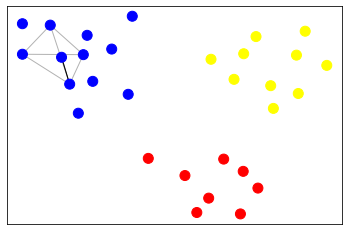

Step:  84  ↑Modularity↑:  0.04061728395061727


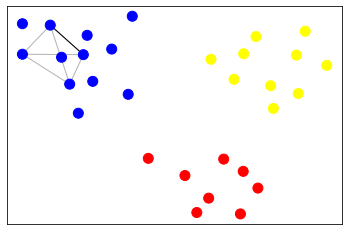

Step:  85  ↑Modularity↑:  0.014506172839506157


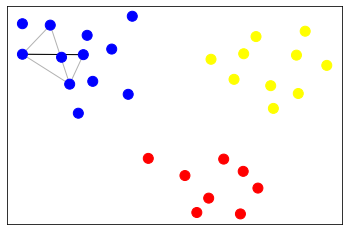

Step:  86  ↑Modularity↑:  0.014506172839506157


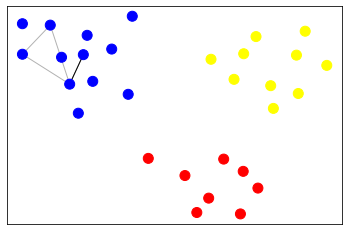

Step:  87  ↑Modularity↑:  0.014506172839506157


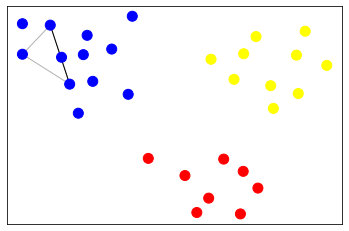

Step:  88  ↑Modularity↑:  -0.009444444444444445


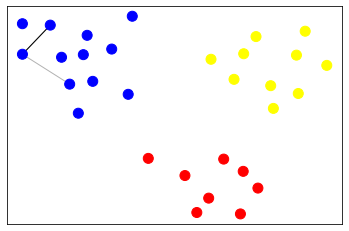

Step:  89  ↑Modularity↑:  -0.009444444444444445


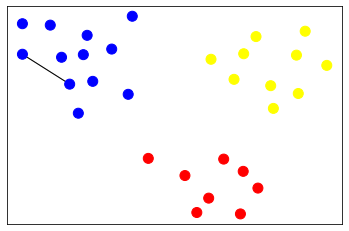

Step:  90  ↑Modularity↑:  -0.026851851851851856


In [12]:
'''
    maxModG             : 가장 큰 Modularity 값을 가지고 있을 때의 그래프
    maxMod              : 가장 큰 Modularity 값
    maxModCom           : 가장 큰 Modularity 값을 가졌을 때, 커뮤니티의 정보
    maxStep             : 가장 큰 Modularity 값을 가졌을 때, Step 값
    logModularityList   : 각 Step마다의 Modularity 값
'''
maxModG, maxM, maxModCom, maxStep, logModularityList = GirvanNewmanAlgorithm(G, nodeColorList)

- 지워지는 간선: 두껍게
- 초반 지워지는 간선들은 서로 다른 커뮤니티를 연결하는 다리 역할의 간선
- 다리 역할의 간선 우선적으로 삭제

In [ ]:
# 각 Step별로 Modularity 값 플롯
fig = plt.figure()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.plot(range(0,G.number_of_edges()), logModularityList)
plt.xlabel('Step')
plt.ylabel('Modularity')
plt.show()

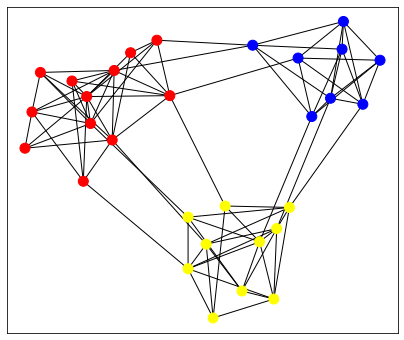

In [13]:
""" 그래프 출력 """
# 군집성 토대로 선정된 최종 군집 시각화

# nx.spring_layout : 정점들의 위치 결정, 정점들의 위치를 신중하게 결정해 간선들이 최대한 중첩되지 않도록 한다
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(7, 6))

# predictedNodeColorList : 정점의 색을 결정해 넣어준다
predictedNodeColorList = []                         # 예측한 커뮤니티에 따라서, 노드별의 색깔을 담은 리스트
for i in range(len(G.nodes)):                       # 각 노드 별로 인덱스에 맞추어 
    # maxModCom : 군집성이 최대화되는 시점의 군집 정보 저장
    # 0번 군집에 속할 경우
    if i in maxModCom[0]:                           # 커뮤니티 별로 색깔을 지정해준다
        predictedNodeColorList = predictedNodeColorList + ['red']
    # 1번 군집에 속할 경우
    elif i in maxModCom[1]:
        predictedNodeColorList = predictedNodeColorList + ['yellow']
    # 2번 군집에 속할 경우
    elif i in maxModCom[2]:
        predictedNodeColorList = predictedNodeColorList + ['blue']

nx.draw_networkx_nodes(G, pos, node_color=predictedNodeColorList, node_size=100)
nx.draw_networkx_edges(G, pos)
plt.show()

### 가라테 동아리 그래프를 불러와 분석, 시각화
- 동아리 분열되어 두 개의 그룹으로 나눠졌다
- 주어진 레이블은 동아리가 둘로 분열되었을 때, 어느 쪽에 속했는지 의미

In [14]:
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import kernighan_lin_bisection

'''
    Karate Club Graph
    # of nodes :  34
    # of edges :  78
    Label : ['Mr.Hi', 'Officer']
'''

# 가라테 동아리 그래프 - nx에 내장
G = nx.karate_club_graph()                              # Karate Club Graph 데이터 불러오기
label = [G.nodes[i]["club"] for i in range(len(G.nodes))]
pos = nx.spring_layout(G)

def plotResult(G, pos, com):
    '''
        Community가 주어진다면, 해당 커뮤니티별로 노드의 색깔을 달리하여 그래프를 출력한다.
    '''
    nodeColorList = [0] * G.number_of_nodes()

    colors = ['red','blue','green','purple']            # 최대 4개의 커뮤니티
    for i in range(len(com)):
        for node in com[i]:
            nodeColorList[node] = colors[i];      
    nx.draw_networkx_nodes(G, pos, node_color=nodeColorList, node_size=100)
    nx.draw_networkx_edges(G, pos)
    plt.plot()

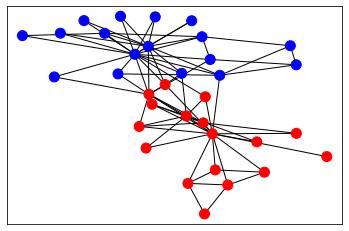

In [15]:
nodeColorList = []
for i in range(len(G.nodes)):                       # 각 노드 별로 인덱스에 맞추어 
    if label[i] == 'Mr. Hi':                        # 커뮤니티 별로 색깔을 지정해준다
        nodeColorList = nodeColorList + ['red']
    elif label[i] == 'Officer':
        nodeColorList = nodeColorList + ['blue']

nx.draw_networkx_nodes(G,pos, node_color=nodeColorList, node_size=100)  # 정점 출력
nx.draw_networkx_edges(G, pos)  # 간선 출력
plt.show()

- 어떤 정점이 어떤 균열된 그룹에 속하는지에 대한 정보 없이도 추론이 가능할까? -> Girvan-Newman 알고리즘 사용
- 거의 완벽하게 소속 관계 예측해낸다
- 어떤 정점이 어떤 균열된 그룹에 속하는지 label로 없어도, 그래프의 구조 분석함으로써 추론해낼 수 있다
- 추론의 정확도가 굉장히 높다

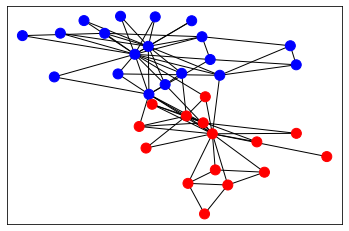

In [16]:
comKarateList  = list(girvan_newman(G))     # Girvan-Newman 알고리즘의 경우, 각 step마다의 community가 저장되어 있기때문에 커뮤니티가 2개로 나누어진 시점의 Community를 가져온다.
for com in comKarateList:
    if len(com) == 2:
        comKarate = com
plotResult(G, pos, comKarate)

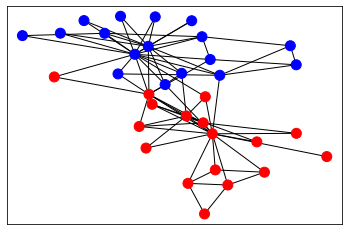

In [17]:
comKarate  = list(kernighan_lin_bisection(G))
plotResult(G, pos, comKarate)